In [11]:
prediction de l evolution mensuelle des passagers 

In [6]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

Série airpass : nombre mensuel de passagers aériens, en milliers, de janvier 1949 à décembre 1960. 
Série brute :

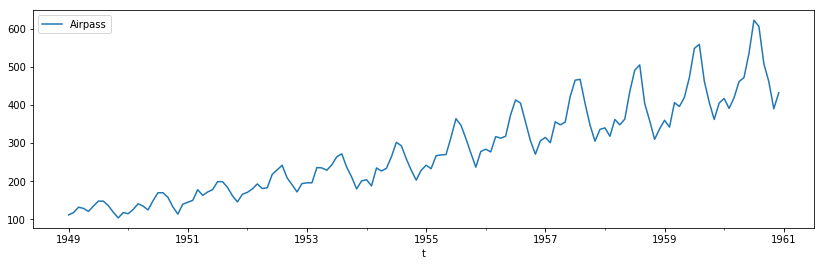

In [7]:
AirPassengers = pd.read_csv("AirPassengers.csv", parse_dates=[0], dayfirst=True, index_col="t")
AirPassengers.plot(y="Airpass", figsize=(14,4))

In [8]:
AirPassengers

,Airpass
t,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
1949-06-01,135
1949-07-01,148
1949-08-01,148
1949-09-01,136


Logarithme de la série airpass 

on passe au logorathmithe de notre serie pour pour avoir un modele additif(pour palier a l'accroissement des saisonnalités)

petit rappel :un model additif est une série ou l'ecart entre le max et le min de l'année ne varie pas au cours du temps

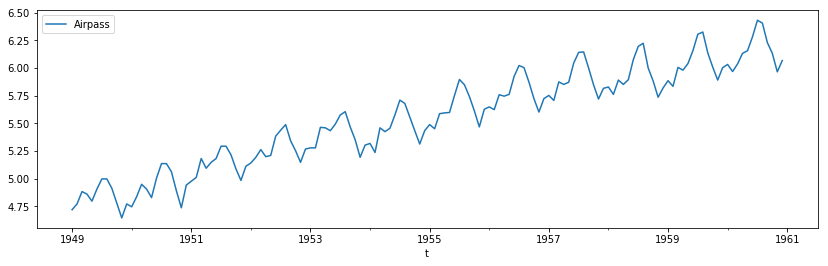

In [9]:
np.log(AirPassengers).plot(y="Airpass", figsize=(14,4))

In [11]:
import numpy as np
x = AirPassengers
y = np.log(AirPassengers)

on remarque bien ici que notre série a une tendance croissante et est saisonniere de periode 12 

on va donc dans la  suite asseyaer de la désaisonnaliser

#Metode des moyennes mobiles

On utilise la fonction "seasonal_decompose" du package statsmodels :

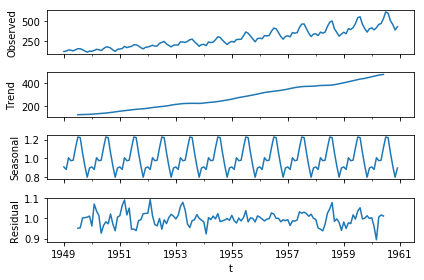

In [12]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

decomp_x = seasonal_decompose(x,  model='multiplicative')
decomp_x.plot()
plt.show()

prédiction de la serie a l'aide du lissage exponetielle simple et double 

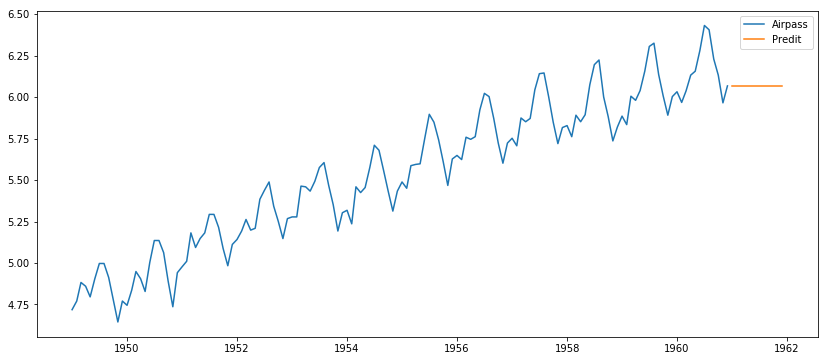

In [13]:
from statsmodels.tsa.api import ExponentialSmoothing

les = ExponentialSmoothing(np.asarray(y['Airpass']), trend=None, seasonal=None).fit()
les_pred = les.forecast(12)

plt.figure(figsize=(14,6))
plt.plot(y['Airpass'], label='Airpass')
plt.plot(pd.date_range(y.index[len(y)-1], periods=12, freq='M'), les_pred, label='Predit')
plt.legend()
plt.show()

Pour le lissage exponentiel double :

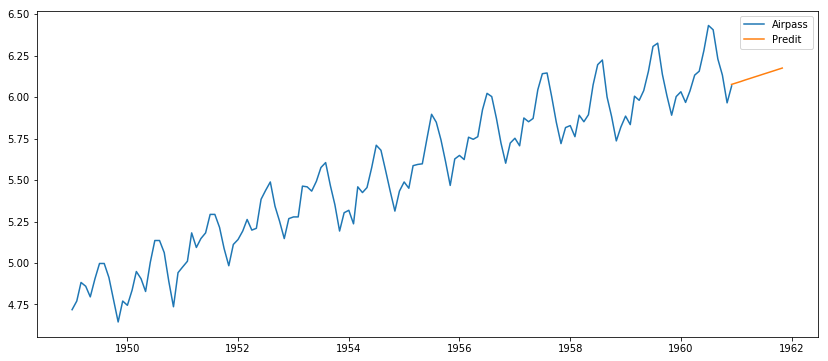

In [14]:
led = ExponentialSmoothing(np.asarray(y['Airpass']), trend='mul', seasonal=None).fit()
led_pred = led.forecast(12)

plt.figure(figsize=(14,6))
plt.plot(y['Airpass'], label='Airpass')
plt.plot(pd.date_range(y.index[len(y)-2], periods=12, freq='M'), led_pred, label='Predit')
plt.legend()
plt.show()

Et enfin pour la méthode de Holt-Winters :

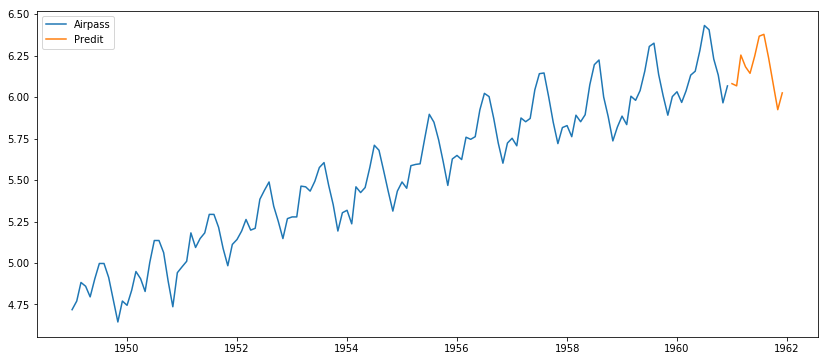

In [59]:
hw = ExponentialSmoothing(np.asarray(y['Airpass']), seasonal_periods=12, trend='mul', seasonal='mul').fit()
hw_pred = hw.forecast(12)

plt.figure(figsize=(14,6))
plt.plot(y['Airpass'], label='Airpass')
plt.plot(pd.date_range(y.index[len(y)-1], periods=12, freq='M'), hw_pred, label='Predit')
plt.legend()
plt.show()

 ##on remarque bien que le modele de holt_winter prédit mieux que le lissage exponetielle simple et le lissage exponentielle double

In [ ]:
#prévision avec les model Arima 

####  le modele arima s'appliquant sur  des series modélisées par des processus stochastiques  stationnaires
###on commencera par vérifié la stationnarité de la série

on rappel qu'on travaille sur le logarithme de la série afin de pallier a l’accroissement de la saisonnalité. On passe ainsi d’un modèle multiplicatif à un modèle additif comme décrit plus haut.

Pour cela on trace le coefficient d 'autocorrelation  de la série

si elle décroit rapidement vers 0 elle est stationnaire 

sinon elle est non stationnaire 

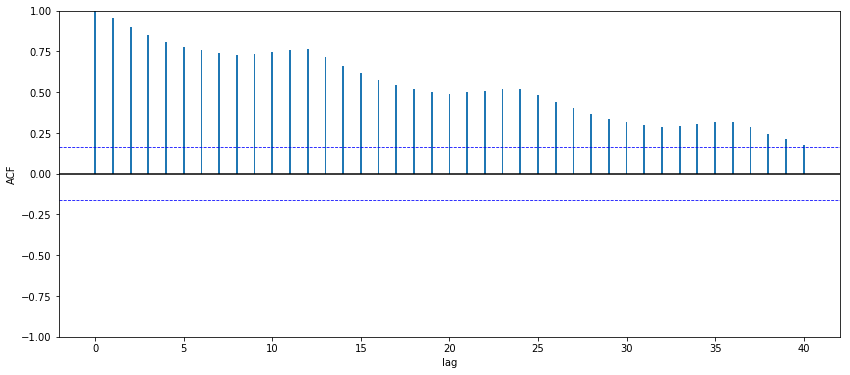

In [21]:
from statsmodels.tsa.stattools import acf, pacf
from functions import plot_sortie_acf

y_len = len(y['Airpass']) # variable nécessaire pour l'utilisation de plot_sortie_acf

plot_sortie_acf(acf(np.asarray(y['Airpass'])), y_len)

La sortie ACF présente une décroissance lente vers 0, ce qui traduit un problème de non-stationnarité. On effectue donc une différenciation $(I−B)$ . qui traduit la difference entre un instant présent et un instant passé

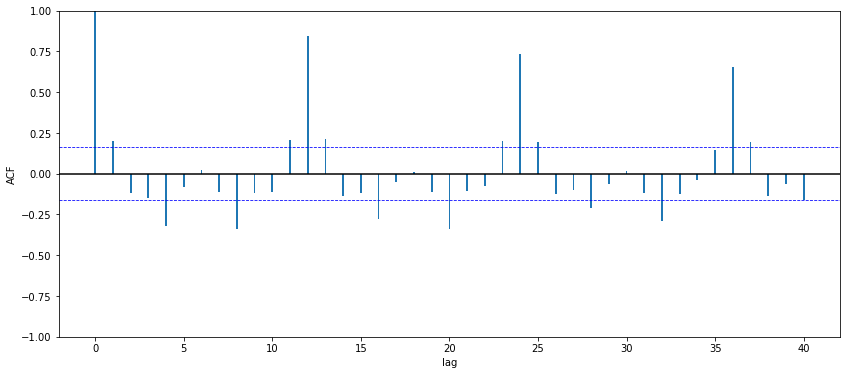

In [22]:
y_dif1 = y['Airpass'] - y['Airpass'].shift(1)

plot_sortie_acf(acf(np.asarray(y_dif1[1:])), y_len)

La sortie ACF de la série ainsi différenciée présente encore une décroissance lente vers 0 pour les multiples de 12. On effectue cette fois la différenciation $(I−B^{12})$ .

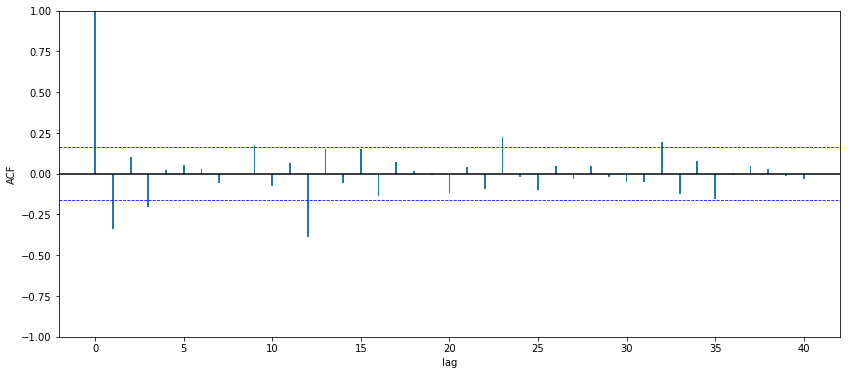

In [23]:
y_dif_1_12 = y_dif1 - y_dif1.shift(12)

plot_sortie_acf(acf(np.asarray(y_dif_1_12[13:])), y_len)

#### Identification, estimation et validation de modèles

On s’appuie sur les autocorrélogrammes simple et partiels estimés :

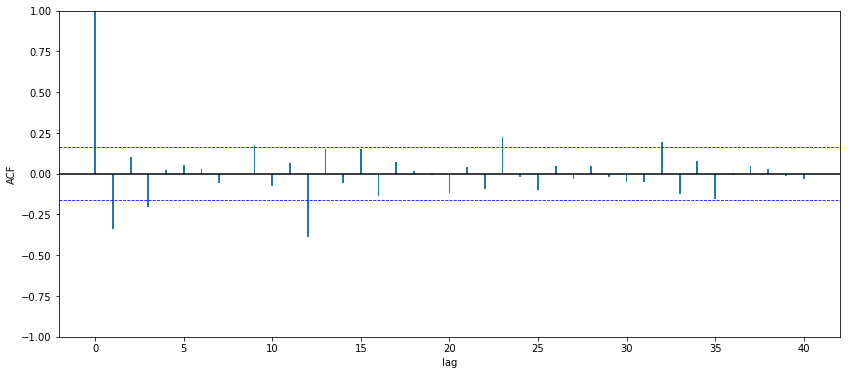

In [24]:
y_dif_1_12 = y_dif1 - y_dif1.shift(12)

plot_sortie_acf(acf(np.asarray(y_dif_1_12[13:])), y_len)

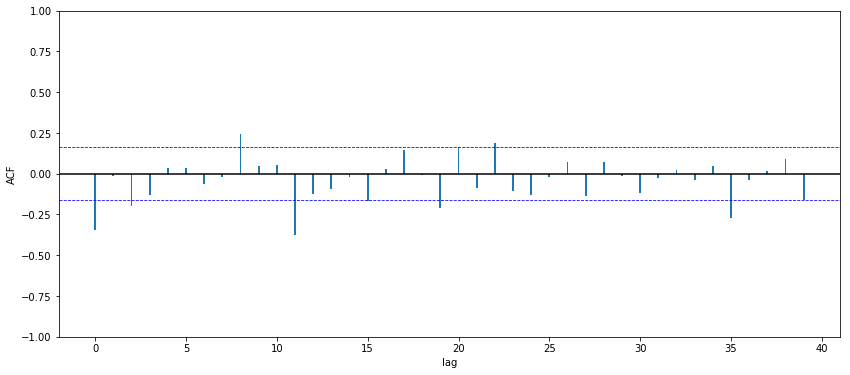

In [25]:
plot_sortie_acf(pacf(np.asarray(y_dif_1_12[13:])), y_len, pacf=True)

#### Modèle 1

On estime en premier lieu un modèle $SARIMA(1,1,1)(1,1,1)_{12}$ au vu des autocorrélogrammes empiriques simples et partiels. Ce modèle s’écrit :

$$(I−φ_{1}B)(I−φ′_{1}B^{12})(I−B)(I−B^{12})ln(X_{t})=(I+θ_{1}B)(I+θ′_{1}B^{12})ε_{t} $$

In [26]:
from statsmodels.tsa.statespace.sarimax import *
from statsmodels.stats.diagnostic import acorr_ljungbox

model1 = SARIMAX(np.asarray(y['Airpass']), order=(1,1,1), seasonal_order=(1,1,1,12))
results1 = model1.fit()
print(results1.summary())

print('Retard : p-value')
for elt in [6, 12, 18, 24, 30, 36]:
    print('{} : {}'.format(elt, acorr_ljungbox(results1.resid, lags=elt)[1].mean()))

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                  144
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 245.151
Date:                            Sat, 18 Aug 2018   AIC                           -480.303
Time:                                    17:50:23   BIC                           -465.927
Sample:                                         0   HQIC                          -474.461
                                            - 144                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1616      0.213      0.757      0.449      -0.257       0.580
ma.L1         -0.5569      0.185   

Ce modèle ayant des paramètres non significatifs, on en teste un second.

#### Modèle 2

Soit le modèle :
$$ (I−φ′_{1}B^{12})(I−B)(I−B^{12})ln(X_{t})=(I+θ_{1}B)(I+θ′_{1}B^{12})ε_{t} $$

In [27]:
model2 = SARIMAX(np.asarray(y['Airpass']), order=(1,1,1), seasonal_order=(0,1,1,12))
results2 = model2.fit()
print(results2.summary())

print('Retard : p-value')
for elt in [6, 12, 18, 24, 30, 36]:
    print('{} : {}'.format(elt, acorr_ljungbox(results2.resid, lags=elt)[1].mean()))

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                  144
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 244.946
Date:                            Sat, 18 Aug 2018   AIC                           -481.893
Time:                                    17:50:25   BIC                           -470.392
Sample:                                         0   HQIC                          -477.220
                                            - 144                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1969      0.199      0.989      0.322      -0.193       0.587
ma.L1         -0.5790      0.171   

Ce modèle ayant des paramètres non significatifs, on en teste un troisième.

#### Modèle 3

Soit le modèle :
$$ (I−B)(I−B^{12})ln(X_{t})=(I+θ_{1}B)(I+θ′_{1}B^{12})ε_{t}$$

In [28]:
model3 = SARIMAX(np.asarray(y['Airpass']), order=(0,1,1), seasonal_order=(0,1,1,12))
results3 = model3.fit()
print(results3.summary())

print('Retard : p-value')
for elt in [6, 12, 18, 24, 30, 36]:
    print('{} : {}'.format(elt, acorr_ljungbox(results3.resid, lags=elt)[1].mean()))

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                  144
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 244.696
Date:                            Sat, 18 Aug 2018   AIC                           -483.393
Time:                                    17:50:27   BIC                           -474.767
Sample:                                         0   HQIC                          -479.888
                                            - 144                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4019      0.073     -5.503      0.000      -0.545      -0.259
ma.S.L12      -0.5569      0.096   

Les tests de significativité des paramètres et de blancheur du résidu sont validés au niveau 5%.

In [29]:
from scipy.stats import shapiro

shapiro(results3.resid)

(0.168989896774292, 5.187279620911401e-25)

Le test de normalité est également validé pour ce modèle.

#### Prévision à l’aide du modèle retenu (3) de l’année 1961

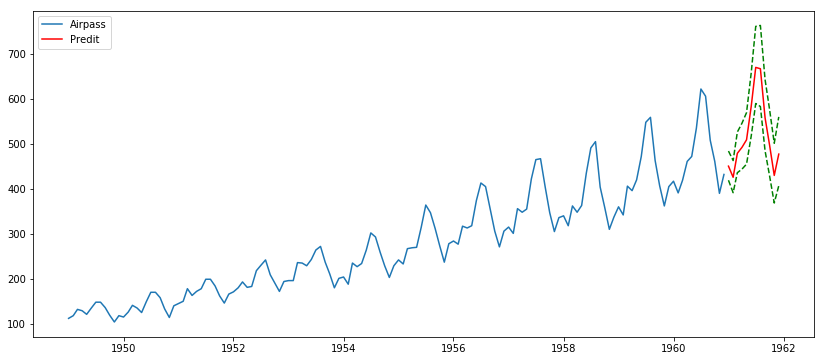

In [30]:
pred_model3 = results3.get_forecast(12)
pred = np.exp(pred_model3.predicted_mean)
pred_l = [np.exp(elt[0]) for elt in pred_model3.conf_int(alpha=0.05)]
pred_u = [np.exp(elt[1]) for elt in pred_model3.conf_int(alpha=0.05)]

plt.figure(figsize=(14,6))
plt.plot(x['Airpass'], label='Airpass')
plt.plot(pd.date_range(x.index[len(x)-1], periods=12, freq='M'), pred, color='r', label='Predit')
plt.plot(pd.date_range(x.index[len(x)-1], periods=12, freq='M'), pred_l, color='g', linestyle='--')
plt.plot(pd.date_range(x.index[len(x)-1], periods=12, freq='M'), pred_u, color='g', linestyle='--')
plt.legend()
plt.show()

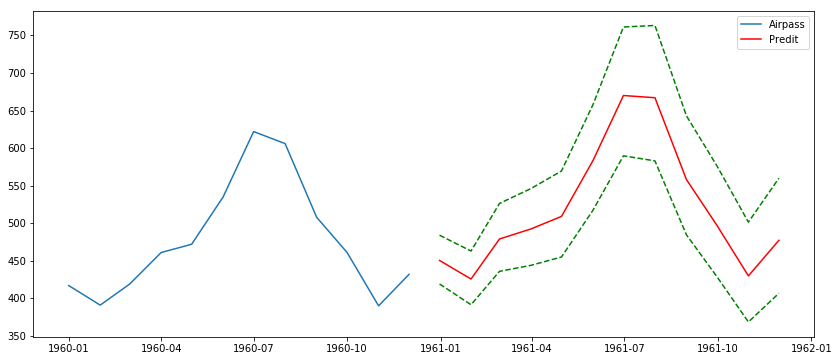

In [31]:
plt.figure(figsize=(14,6))
plt.plot(x['Airpass']['1960':], label='Airpass')
plt.plot(pd.date_range(x.index[len(x)-1], periods=12, freq='M'), pred, color='r', label='Predit')
plt.plot(pd.date_range(x.index[len(x)-1], periods=12, freq='M'), pred_l, color='g', linestyle='--')
plt.plot(pd.date_range(x.index[len(x)-1], periods=12, freq='M'), pred_u, color='g', linestyle='--')
plt.legend()
plt.show()

#### Analyse a posteriori

On tronque la série de l’année 1960, qu’on cherche ensuite à prévoir à partir de l’historique 1949-1959.

In [32]:
x_tronc = x[:'1959']
y_tronc = np.log(x_tronc)
x_a_prevoir = x['1960':]

On vérifie que le modèle 3 sur la série tronquée est toujours validé.

In [33]:
model3tronc = SARIMAX(np.asarray(y_tronc['Airpass']), order=(0,1,1), seasonal_order=(0,1,1,12))
results3tronc = model3tronc.fit()
print(results3tronc.summary())

print('Retard : p-value')
for elt in [6, 12, 18, 24, 30, 36]:
    print('{} : {}'.format(elt, acorr_ljungbox(results3tronc.resid, lags=elt)[1].mean()))
    
shapiro(results3tronc.resid)

                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                  132
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood                 223.627
Date:                            Sat, 18 Aug 2018   AIC                           -441.253
Time:                                    17:50:34   BIC                           -432.916
Sample:                                         0   HQIC                          -437.868
                                            - 132                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3481      0.081     -4.298      0.000      -0.507      -0.189
ma.S.L12      -0.5622      0.094   

(0.17491132020950317, 5.4857261131324326e-24)

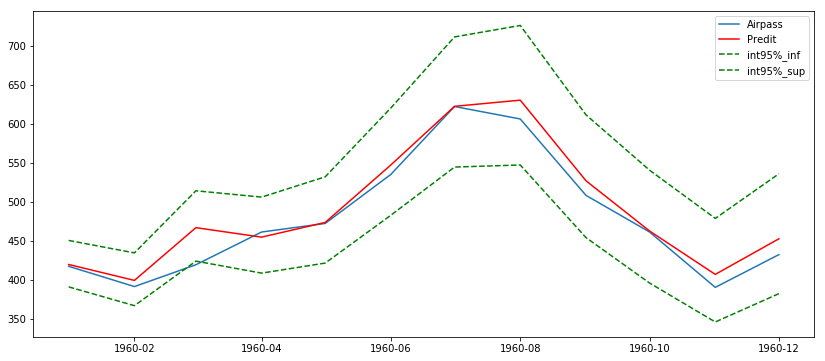

In [34]:
pred_model3tronc = results3tronc.get_forecast(12)
pred_tronc = np.exp(pred_model3tronc.predicted_mean)
pred_l_tronc = [np.exp(elt[0]) for elt in pred_model3tronc.conf_int(alpha=0.05)]
pred_u_tronc = [np.exp(elt[1]) for elt in pred_model3tronc.conf_int(alpha=0.05)]

plt.figure(figsize=(14,6))
plt.plot(x_a_prevoir, label='Airpass')
plt.plot(x_a_prevoir.index, pred_tronc, color='r', label='Predit')
plt.plot(x_a_prevoir.index, pred_l_tronc, color='g', linestyle='--', label='int95%_inf')
plt.plot(x_a_prevoir.index, pred_u_tronc, color='g', linestyle='--', label='int95%_sup')
plt.legend()
plt.show()

On calcule les RMSE et MAPE.

In [35]:
rmse = np.sqrt(((x_a_prevoir['Airpass']-pred_tronc)**2).mean())
rmse

18.596338709271038

In [36]:
mape=(np.abs(1-pred_tronc/x_a_prevoir['Airpass'])).mean()*100
mape

2.9052134422486082